<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLRankingsCharts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Install the library for NFL Data
!pip install nfl_data_py
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Import Play By Play Dataset
pbp = nfl.import_pbp_data([2022, 2023], downcast=True)
pbp = pbp[pbp["season_type"] =='REG']
pbp2022 = pbp[pbp["season"] == 2022]
pbp2023 = pbp[pbp["season"] == 2023]

2022 done.
2023 done.
Downcasting floats.


# **NFL Rankings 2023**

<Figure size 1400x1000 with 0 Axes>

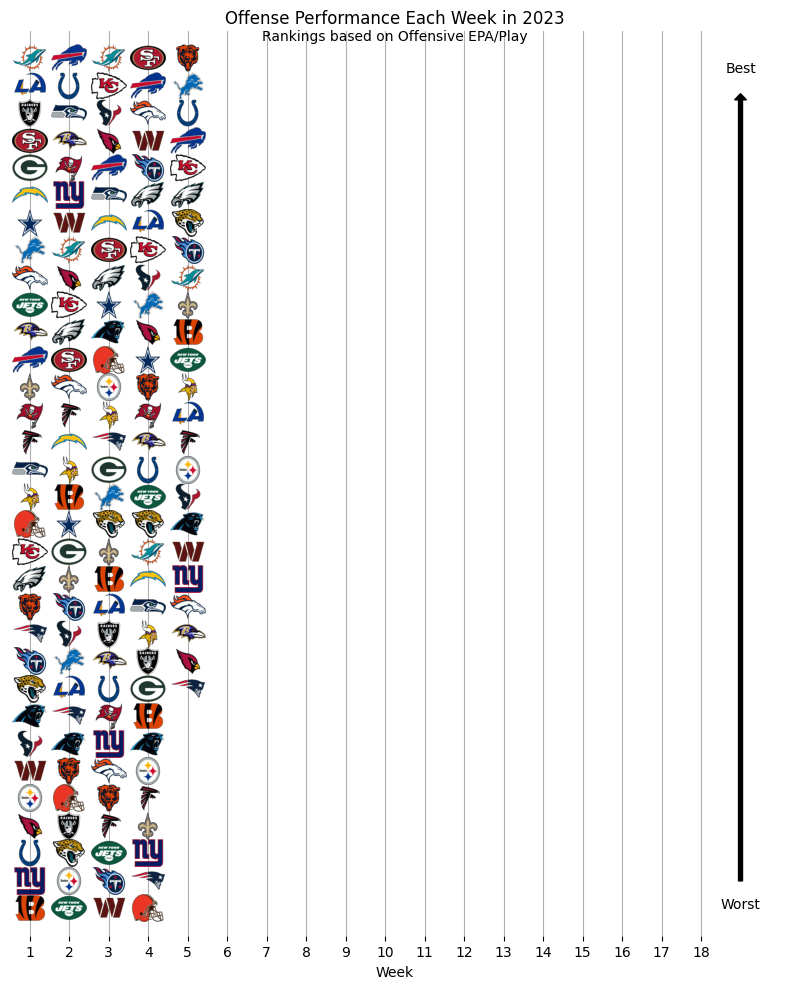

In [35]:
# DATA AUGMENT
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["posteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["posteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

epa_weeks = []

for week in range(1, max(epa_week["week"])+1):
    epa_week_temp = epa_week[epa_week["week"] == week].reset_index(drop=True)
    epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=False).reset_index(drop=True)
    epa_week_temp['rank'] = range(1, len(epa_week_temp)+1)
    epa_weeks.append(epa_week_temp)

epa_weeks = pd.concat(epa_weeks, axis=0).reset_index(drop=True)


# CREAT CHART
logo_images = []

for team in epa_weeks["posteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

plt.figure(figsize=(14, 10))
fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legend
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(epa_weeks.index)):
    x, y = epa_weeks["week"][i] , epa_weeks["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Offense Performance Each Week in 2023')
plt.text(0.5, 0.99, 'Rankings based on Offensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
#plt.yticks(range(0, 66, 1))
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

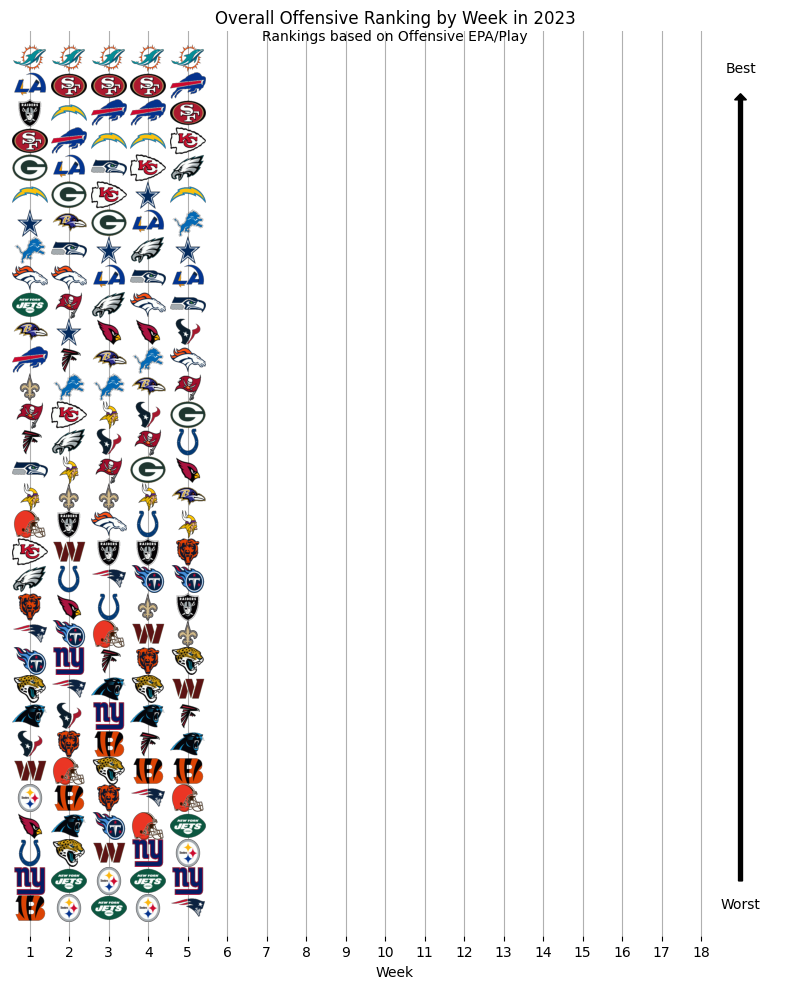

In [36]:
# DATA AUGMENT
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["posteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["posteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

# Sort the DataFrame by 'posteam' and 'week'
epa_week.sort_values(by=['posteam', 'week'], inplace=True)

team_mapping = {'Team 1': "ARI", "Team 2": "ATL", "Team 3": "BAL", "Team 4": "BUF", "Team 5": "CAR", "Team 6": "CHI", "Team 7": "CIN", "Team 8": "CLE", "Team 9": "DAL", "Team 10": "DEN",
                  "Team 11": "DET", "Team 12": "GB", "Team 13": "HOU", "Team 14": "IND", "Team 15": "JAX", "Team 16": "KC", "Team 17": "LV", "Team 18": "LAC", "Team 19": "LA", "Team 20": "MIA",
                    "Team 21": "MIN", "Team 22": "NE", "Team 23": "NO", "Team 24": "NYG", "Team 25": "NYJ", "Team 26": "PHI", "Team 27": "PIT", "Team 28": "SF", "Team 29": "SEA", "Team 30": "TB",
                      "Team 31": "TEN", "Team 32": "WAS"}

# Create Dummy df for bye weeks
weeks = list(range(1, 6))
teams = ['Team {}'.format(i) for i in range(1, 33)]
all_teams = pd.DataFrame([(week, team) for week in weeks for team in teams], columns=['week', 'posteam'])
all_teams['posteam'] = all_teams['posteam'].replace(team_mapping)

# Combine the dfs
merged_data = all_teams.merge(epa_week, on=['week', 'posteam'], how='left')
merged_data['epa_per_play'] = merged_data['epa_per_play'].fillna(0)

# Create new df for cumulative EPA per play
cumulative_data = pd.DataFrame()

# Iterate over unique teams in the DataFrame
for team in merged_data['posteam'].unique():
    # Filter the data for the current team
    team_data = merged_data[merged_data['posteam'] == team].copy()

    # Initialize a new column
    team_data['cumulative_epa_per_play'] = 0.0

    # Iterate over unique weeks for the current team
    for week in team_data['week'].unique():
        cumulative_epa_per_play = team_data[team_data['week'] <= week]['epa_per_play'].sum()
        team_data.loc[team_data['week'] == week, 'cumulative_epa_per_play'] = cumulative_epa_per_play

    # Add teams data to cumulative_data
    cumulative_data = pd.concat([cumulative_data, team_data], ignore_index=True)

# Sort the data
cumulative_data.sort_values(by=['posteam', 'week'], inplace=True)

# Reset the index
cumulative_data.reset_index(drop=True, inplace=True)
cumulative_data = cumulative_data.sort_values(by=["week",'cumulative_epa_per_play'], ascending=[True, False]).reset_index(drop=True)

# Calculate the rank for each team
cumulative_data['rank'] = cumulative_data.groupby('week')['epa_per_play'].rank(ascending=True)
cumulative_data['rank'] = 32 - cumulative_data['rank'] + 1
cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=False)


# CREATE CHART
logo_images = []

for team in cumulative_data["posteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legends
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(cumulative_data.index)):
    x, y = cumulative_data["week"][i] , cumulative_data["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Overall Offensive Ranking by Week in 2023')
plt.text(0.5, 0.99, 'Rankings based on Offensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

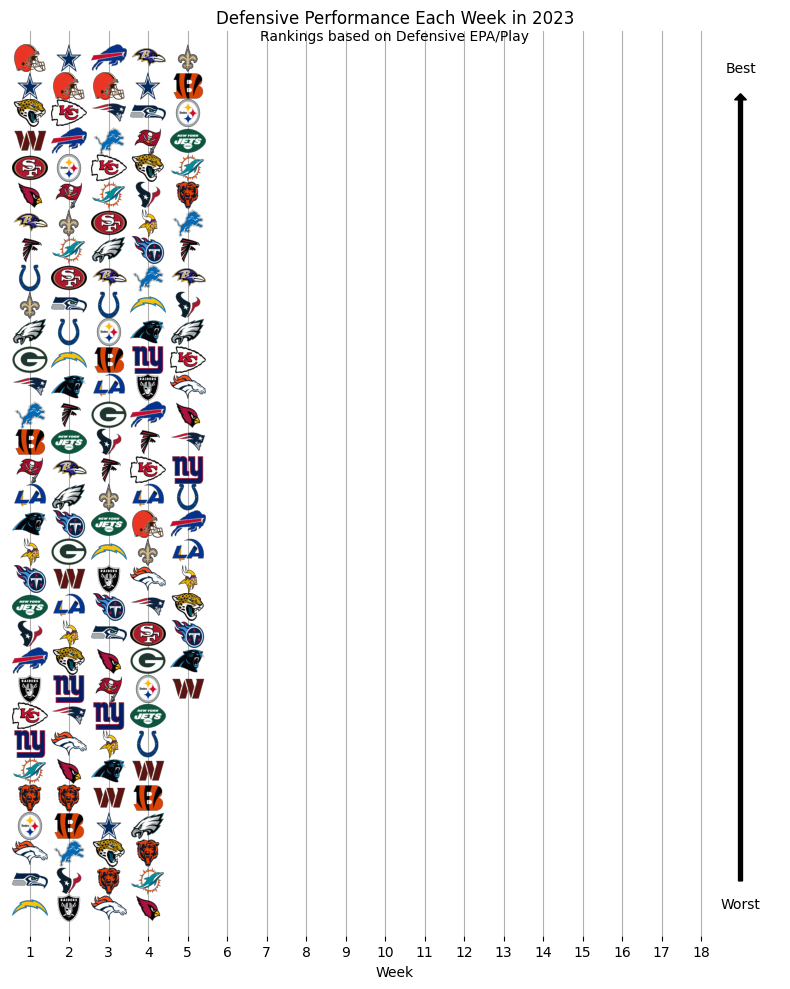

In [37]:
# DATA AUGMENT
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["defteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["defteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

epa_weeks = []

for week in range(1, max(epa_week["week"])+1):
    epa_week_temp = epa_week[epa_week["week"] == week].reset_index(drop=True)
    epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=True).reset_index(drop=True)
    epa_week_temp['rank'] = range(1, len(epa_week_temp)+1)
    epa_weeks.append(epa_week_temp)

epa_weeks = pd.concat(epa_weeks, axis=0).reset_index(drop=True)


# CREATE CHART
logo_images = []

for team in epa_weeks["defteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)


plt.figure(figsize=(14, 10))

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legends
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(epa_weeks.index)):
    x, y = epa_weeks["week"][i] , epa_weeks["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Defensive Performance Each Week in 2023')
plt.text(0.5, 0.99, 'Rankings based on Defensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

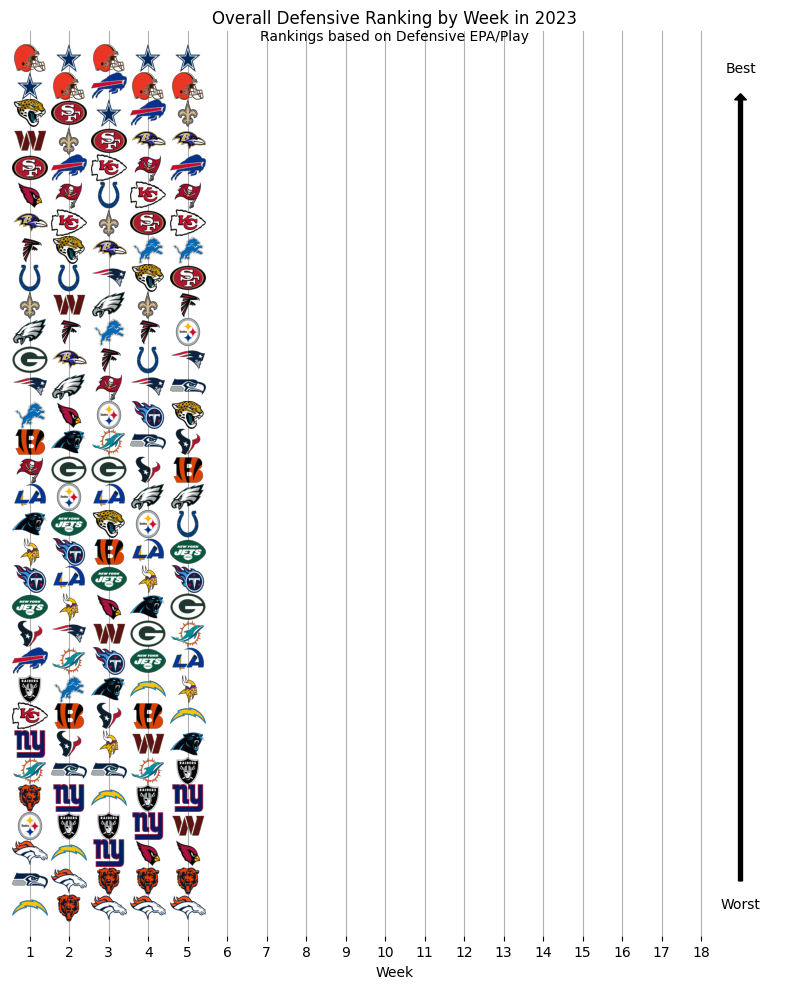

In [38]:
# DATA AUGMENT
pbp_week = pbp2023[pbp2023["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["defteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["defteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

# Sort the data
epa_week.sort_values(by=['defteam', 'week'], inplace=True)

team_mapping = {'Team 1': "ARI", "Team 2": "ATL", "Team 3": "BAL", "Team 4": "BUF", "Team 5": "CAR", "Team 6": "CHI", "Team 7": "CIN", "Team 8": "CLE", "Team 9": "DAL", "Team 10": "DEN",
                  "Team 11": "DET", "Team 12": "GB", "Team 13": "HOU", "Team 14": "IND", "Team 15": "JAX", "Team 16": "KC", "Team 17": "LV", "Team 18": "LAC", "Team 19": "LA", "Team 20": "MIA",
                    "Team 21": "MIN", "Team 22": "NE", "Team 23": "NO", "Team 24": "NYG", "Team 25": "NYJ", "Team 26": "PHI", "Team 27": "PIT", "Team 28": "SF", "Team 29": "SEA", "Team 30": "TB",
                      "Team 31": "TEN", "Team 32": "WAS"}

# Create Dummy df for bye weeks
weeks = list(range(1, 6))
teams = ['Team {}'.format(i) for i in range(1, 33)]
all_teams = pd.DataFrame([(week, team) for week in weeks for team in teams], columns=['week', 'defteam'])
all_teams['defteam'] = all_teams['defteam'].replace(team_mapping)

# Combine the dfs
merged_data = all_teams.merge(epa_week, on=['week', 'defteam'], how='left')
merged_data['epa_per_play'] = merged_data['epa_per_play'].fillna(0)

# Create new df for cumulative EPA per play
cumulative_data = pd.DataFrame()

# Iterate over unique teams in the DataFrame
for team in merged_data['defteam'].unique():
    # Filter the data for the current team
    team_data = merged_data[merged_data['defteam'] == team].copy()

    # Initialize a new column
    team_data['cumulative_epa_per_play'] = 0.0

    # Iterate over unique weeks for the current team
    for week in team_data['week'].unique():
        cumulative_epa_per_play = team_data[team_data['week'] <= week]['epa_per_play'].sum()
        team_data.loc[team_data['week'] == week, 'cumulative_epa_per_play'] = cumulative_epa_per_play

    # Add teams data to cumulative_data
    cumulative_data = pd.concat([cumulative_data, team_data], ignore_index=True)

# Sort the data
cumulative_data.sort_values(by=['defteam', 'week'], inplace=True)

# Reset the index
cumulative_data.reset_index(drop=True, inplace=True)
cumulative_data = cumulative_data.sort_values(by=["week",'cumulative_epa_per_play'], ascending=[True, False]).reset_index(drop=True)

# Calculate the rank for each team
cumulative_data['rank'] = cumulative_data.groupby('week')['epa_per_play'].rank(ascending=True)
cumulative_data['rank'] = 32 - cumulative_data['rank'] + 1
cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=True)


# CREATE CHART
logo_images = []

for team in cumulative_data["defteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legends
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(cumulative_data.index)):
    x, y = cumulative_data["week"][i] , cumulative_data["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Overall Defensive Ranking by Week in 2023')
plt.text(0.5, 0.99, 'Rankings based on Defensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# **NFL Rankings 2022**

<Figure size 1400x1000 with 0 Axes>

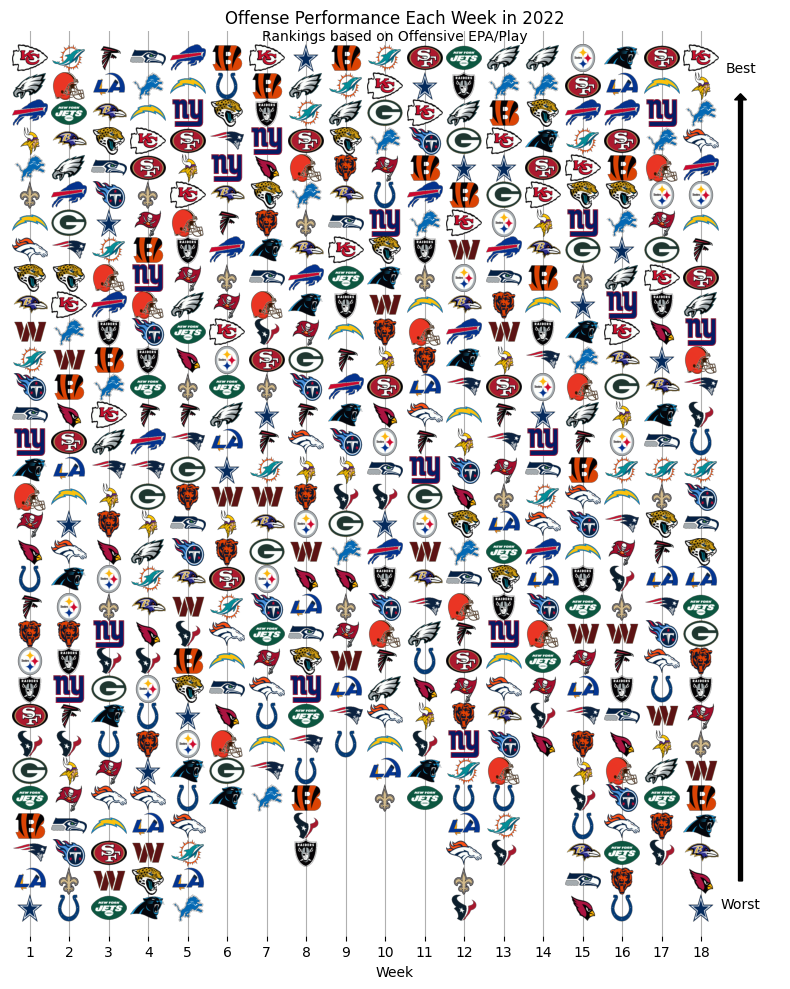

In [39]:
# DATA AUGMENT
pbp_week = pbp2022[pbp2022["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["posteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["posteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

epa_weeks = []

for week in range(1, max(epa_week["week"])+1):
    epa_week_temp = epa_week[epa_week["week"] == week].reset_index(drop=True)
    epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=False).reset_index(drop=True)
    epa_week_temp['rank'] = range(1, len(epa_week_temp)+1)
    epa_weeks.append(epa_week_temp)

epa_weeks = pd.concat(epa_weeks, axis=0).reset_index(drop=True)

# CREAT CHART
logo_images = []

for team in epa_weeks["posteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

plt.figure(figsize=(14, 10))

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legend
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(epa_weeks)):
    x, y = epa_weeks["week"][i] , epa_weeks["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Offense Performance Each Week in 2022')
plt.text(0.5, 0.99, 'Rankings based on Offensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

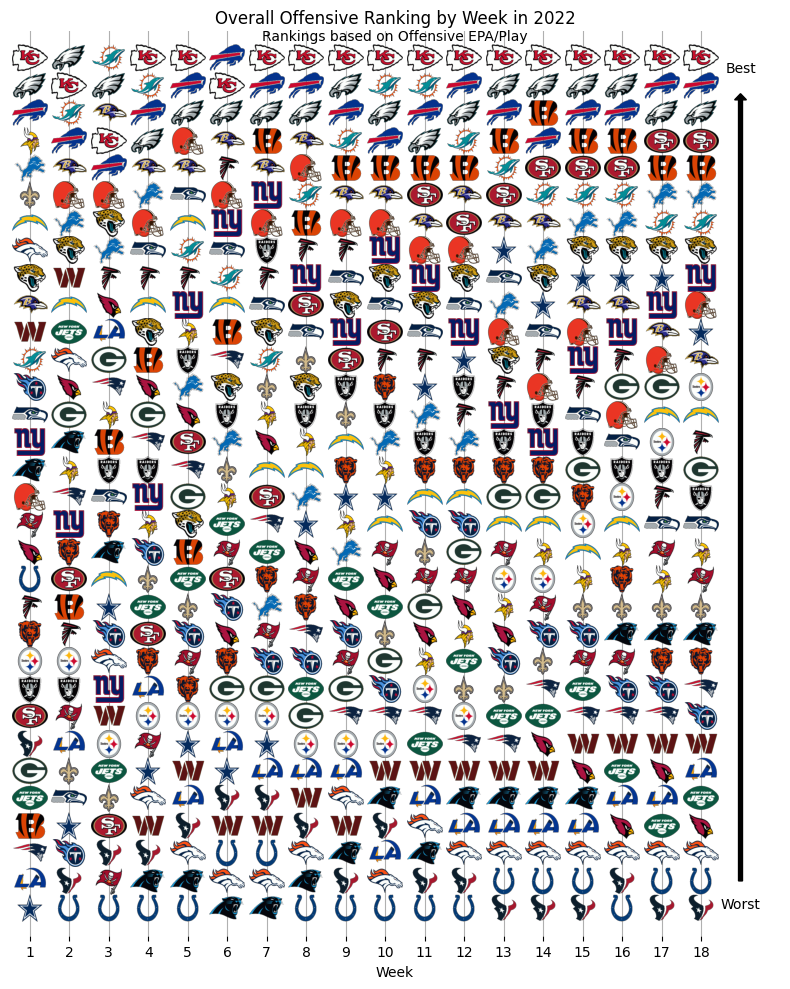

In [40]:
# DATA AUGMENT
pbp_week = pbp2022[pbp2022["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["posteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["posteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

# Sort the DataFrame by 'posteam' and 'week'
epa_week.sort_values(by=['posteam', 'week'], inplace=True)

team_mapping = {'Team 1': "ARI", "Team 2": "ATL", "Team 3": "BAL", "Team 4": "BUF", "Team 5": "CAR", "Team 6": "CHI", "Team 7": "CIN", "Team 8": "CLE", "Team 9": "DAL", "Team 10": "DEN",
                  "Team 11": "DET", "Team 12": "GB", "Team 13": "HOU", "Team 14": "IND", "Team 15": "JAX", "Team 16": "KC", "Team 17": "LV", "Team 18": "LAC", "Team 19": "LA", "Team 20": "MIA",
                    "Team 21": "MIN", "Team 22": "NE", "Team 23": "NO", "Team 24": "NYG", "Team 25": "NYJ", "Team 26": "PHI", "Team 27": "PIT", "Team 28": "SF", "Team 29": "SEA", "Team 30": "TB",
                      "Team 31": "TEN", "Team 32": "WAS"}

# Create Dummy df for bye weeks
weeks = list(range(1, 19))
teams = ['Team {}'.format(i) for i in range(1, 33)]
all_teams = pd.DataFrame([(week, team) for week in weeks for team in teams], columns=['week', 'posteam'])
all_teams['posteam'] = all_teams['posteam'].replace(team_mapping)

# Combine the dfs
merged_data = all_teams.merge(epa_week, on=['week', 'posteam'], how='left')
merged_data['epa_per_play'] = merged_data['epa_per_play'].fillna(0)

# Create new df for cumulative EPA per play
cumulative_data = pd.DataFrame()

# Iterate over unique teams in the DataFrame
for team in merged_data['posteam'].unique():
    # Filter the data for the current team
    team_data = merged_data[merged_data['posteam'] == team].copy()

    # Initialize a new column
    team_data['cumulative_epa_per_play'] = 0.0

    # Iterate over unique weeks for the current team
    for week in team_data['week'].unique():
        cumulative_epa_per_play = team_data[team_data['week'] <= week]['epa_per_play'].sum()
        team_data.loc[team_data['week'] == week, 'cumulative_epa_per_play'] = cumulative_epa_per_play

    # Add teams data to cumulative_data
    cumulative_data = pd.concat([cumulative_data, team_data], ignore_index=True)

# Sort the data
cumulative_data.sort_values(by=['posteam', 'week'], inplace=True)

# Reset the index
cumulative_data.reset_index(drop=True, inplace=True)
cumulative_data = cumulative_data.sort_values(by=["week",'cumulative_epa_per_play'], ascending=[True, False]).reset_index(drop=True)

# Calculate the rank for each team
cumulative_data['rank'] = cumulative_data.groupby('week')['epa_per_play'].rank(ascending=True)
cumulative_data['rank'] = 32 - cumulative_data['rank'] + 1
cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=False)


# CREATE CHART
logo_images = []

for team in cumulative_data["posteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legends
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(cumulative_data.index)):
    x, y = cumulative_data["week"][i] , cumulative_data["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Overall Offensive Ranking by Week in 2022')
plt.text(0.5, 0.99, 'Rankings based on Offensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

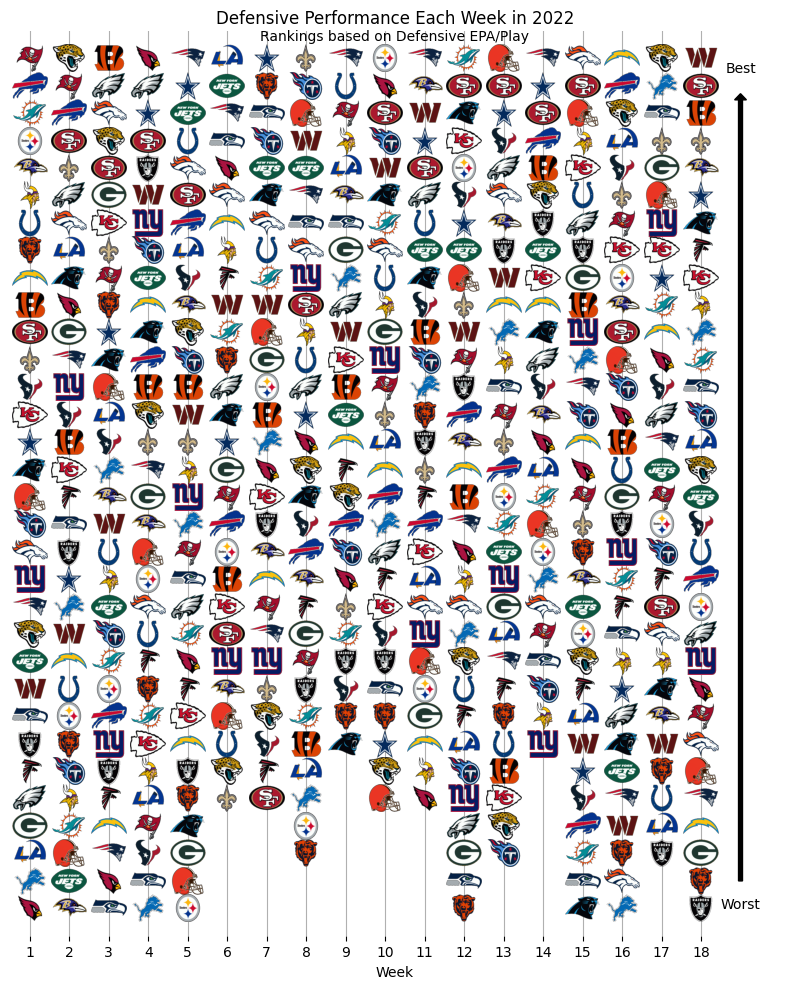

In [41]:
# DATA AUGMENT
pbp_week = pbp2022[pbp2022["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["defteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["defteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

epa_weeks = []

for week in range(1, max(epa_week["week"])+1):
    epa_week_temp = epa_week[epa_week["week"] == week].reset_index(drop=True)
    epa_week_temp = epa_week_temp.sort_values(by="epa_per_play", ascending=True).reset_index(drop=True)
    epa_week_temp['rank'] = range(1, len(epa_week_temp)+1)
    epa_weeks.append(epa_week_temp)

epa_weeks = pd.concat(epa_weeks, axis=0).reset_index(drop=True)

# CREAT CHART
logo_images = []

for team in epa_weeks["defteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

plt.figure(figsize=(14, 10))

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legend
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(epa_weeks)):
    x, y = epa_weeks["week"][i] , epa_weeks["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Defensive Performance Each Week in 2022')
plt.text(0.5, 0.99, 'Rankings based on Defensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

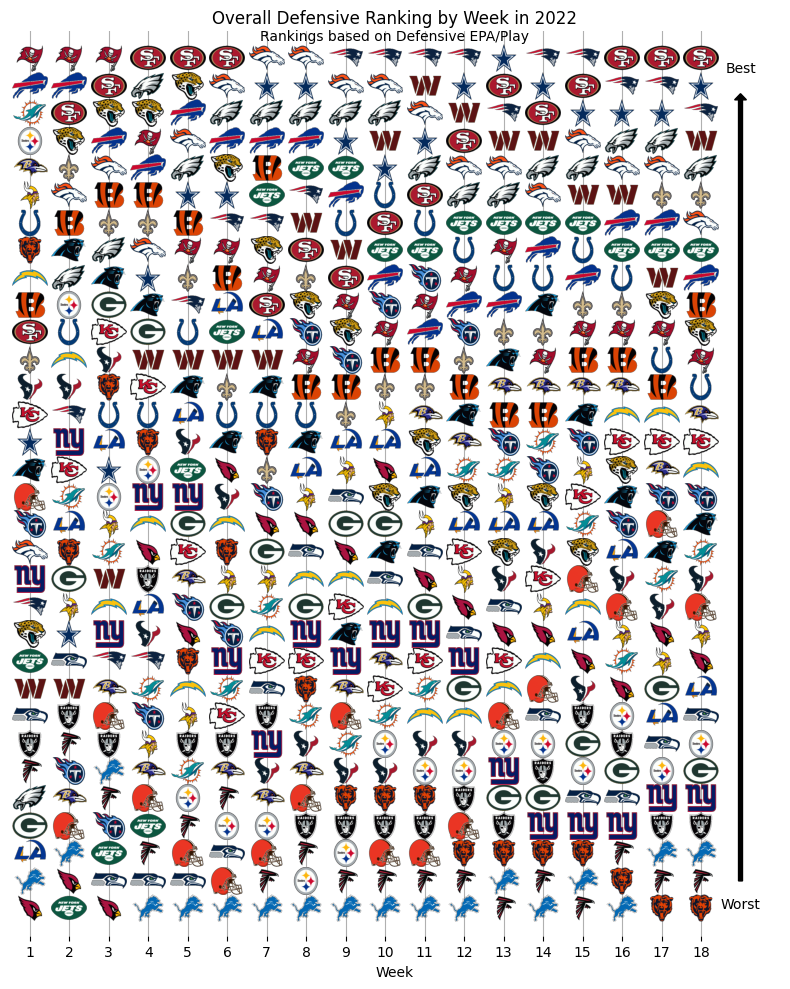

In [42]:
# DATA AUGMENT
pbp_week = pbp2022[pbp2022["play_type"].isin(["pass", "run"])].reset_index(drop=True)

play_per_week = pbp_week.groupby(["defteam", "week"]).size().reset_index()
play_per_week = play_per_week.rename(columns={0: "play_count"})

epa_week = pbp_week.groupby(["defteam", "week"])["epa"].sum().reset_index()

epa_week["epa_per_play"] = epa_week["epa"] / play_per_week["play_count"]

# Sort the data
epa_week.sort_values(by=['defteam', 'week'], inplace=True)

team_mapping = {'Team 1': "ARI", "Team 2": "ATL", "Team 3": "BAL", "Team 4": "BUF", "Team 5": "CAR", "Team 6": "CHI", "Team 7": "CIN", "Team 8": "CLE", "Team 9": "DAL", "Team 10": "DEN",
                  "Team 11": "DET", "Team 12": "GB", "Team 13": "HOU", "Team 14": "IND", "Team 15": "JAX", "Team 16": "KC", "Team 17": "LV", "Team 18": "LAC", "Team 19": "LA", "Team 20": "MIA",
                    "Team 21": "MIN", "Team 22": "NE", "Team 23": "NO", "Team 24": "NYG", "Team 25": "NYJ", "Team 26": "PHI", "Team 27": "PIT", "Team 28": "SF", "Team 29": "SEA", "Team 30": "TB",
                      "Team 31": "TEN", "Team 32": "WAS"}

# Create Dummy df for bye weeks
weeks = list(range(1, 19))
teams = ['Team {}'.format(i) for i in range(1, 33)]
all_teams = pd.DataFrame([(week, team) for week in weeks for team in teams], columns=['week', 'defteam'])
all_teams['defteam'] = all_teams['defteam'].replace(team_mapping)

# Combine the dfs
merged_data = all_teams.merge(epa_week, on=['week', 'defteam'], how='left')
merged_data['epa_per_play'] = merged_data['epa_per_play'].fillna(0)

# Create new df for cumulative EPA per play
cumulative_data = pd.DataFrame()

# Iterate over unique teams in the DataFrame
for team in merged_data['defteam'].unique():
    # Filter the data for the current team
    team_data = merged_data[merged_data['defteam'] == team].copy()

    # Initialize a new column
    team_data['cumulative_epa_per_play'] = 0.0

    # Iterate over unique weeks for the current team
    for week in team_data['week'].unique():
        cumulative_epa_per_play = team_data[team_data['week'] <= week]['epa_per_play'].sum()
        team_data.loc[team_data['week'] == week, 'cumulative_epa_per_play'] = cumulative_epa_per_play

    # Add teams data to cumulative_data
    cumulative_data = pd.concat([cumulative_data, team_data], ignore_index=True)

# Sort the data
cumulative_data.sort_values(by=['defteam', 'week'], inplace=True)

# Reset the index
cumulative_data.reset_index(drop=True, inplace=True)
cumulative_data = cumulative_data.sort_values(by=["week",'cumulative_epa_per_play'], ascending=[True, False]).reset_index(drop=True)

# Calculate the rank for each team
cumulative_data['rank'] = cumulative_data.groupby('week')['epa_per_play'].rank(ascending=True)
cumulative_data['rank'] = 32 - cumulative_data['rank'] + 1
cumulative_data['rank'] = cumulative_data.groupby('week')['cumulative_epa_per_play'].rank(ascending=True)


# CREATE CHART
logo_images = []

for team in cumulative_data["defteam"]:
    logo_img = Image.open(f'/content/drive/My Drive/NFL_AbrevLogos/{team}.png')  # Adjust the path to your logo images
    logo_images.append(logo_img)

fig, ax = plt.subplots(figsize=(8, 10))

# Arrow Legends
plt.arrow(19, 4, 0, 57, width = 0.1, color = "k")
plt.text(19, 63, 'Best', ha='center')
plt.text(19, 2, 'Worst', ha='center')

# Scatter plot with markers replaced by logos
for i in range(len(cumulative_data.index)):
    x, y = cumulative_data["week"][i] , cumulative_data["rank"][i]*2

    # Overlay the logo at each data point
    logo_img = logo_images[i]
    plt.imshow(logo_img, extent=[x-0.45, x+0.45, (abs(64-y)+2)-1, (abs(64-y)+2)+1], aspect='auto', zorder=3)

plt.title('Overall Defensive Ranking by Week in 2022')
plt.text(0.5, 0.99, 'Rankings based on Defensive EPA/Play' , fontsize=10, ha='center', transform=ax.transAxes)

plt.xlabel('Week')
plt.ylabel('')
plt.grid(True)

plt.xlim(0.5,20)
plt.xticks(range(1, 19, 1))

plt.ylim(0, 66)
plt.yticks([])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()